# Tutorial 12-1: The Minimalist – "Diffusion from Scratch (Toy Data)"

**Course:** CSEN 342: Deep Learning  
**Topic:** Denoising Diffusion Probabilistic Models (DDPM), Forward/Reverse Process

## Objective
Modern generative AI (like Stable Diffusion or Sora) is powered by **Diffusion Models**. The core idea is inspired by non-equilibrium thermodynamics:
1.  **Forward Process:** Slowly destroy data by adding noise until it is random chaos.
2.  **Reverse Process:** Learn to reverse time and remove the noise step-by-step to recover structure.

In this tutorial, we will build a diffusion model from scratch for a simple 2D dataset (a Spiral). By avoiding images, we can visualize exactly how the particles move and "flow" back to the data manifold.

---

## Part 1: The Data (A 2D Spiral)

We generate a synthetic dataset. This represents the "complex structure" we want our model to learn.

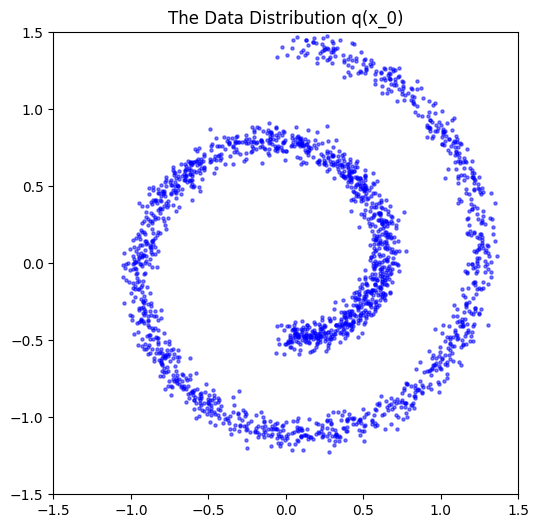

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Generate Data
def get_spiral_data(n_samples=2000):
    # Standard Swiss Roll from sklearn
    data, _ = make_swiss_roll(n_samples=n_samples, noise=0.5)
    # It returns 3D data (x, y, z). We project to 2D (x, z) for simplicity.
    data = data[:, [0, 2]] / 10.0 # Scale down to roughly [-1, 1]
    return torch.tensor(data, dtype=torch.float32)

x0 = get_spiral_data()

# Visualize
plt.figure(figsize=(6, 6))
plt.scatter(x0[:, 0], x0[:, 1], s=5, alpha=0.5, color='blue')
plt.title("The Data Distribution q(x_0)")
plt.xlim(-1.5, 1.5); plt.ylim(-1.5, 1.5)
plt.show()

---

## Part 2: The Forward Process (Adding Noise)

We define a noise schedule $\beta_t$. We want to transition from $x_0$ (Data) to $x_T$ (Gaussian Noise).

The transition kernel is $q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) \mathbf{I})$.

This allows us to sample $x_t$ at any timestep $t$ directly without a loop:
$$ x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon $$

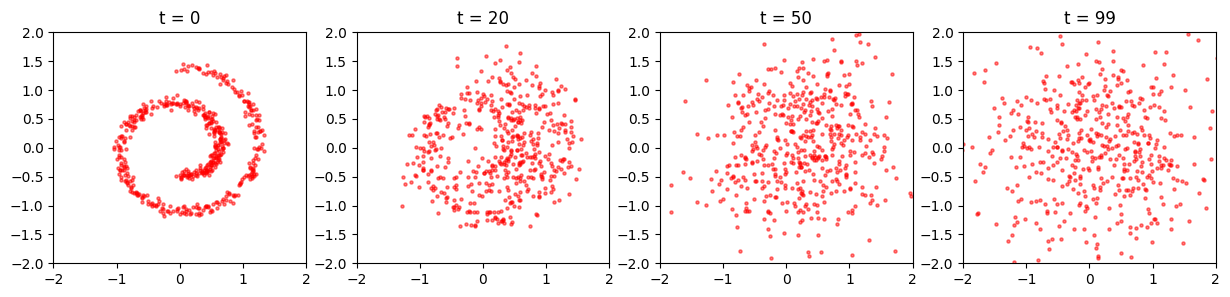

In [2]:
# Diffusion Hyperparameters
n_steps = 100
beta_start = 1e-4
beta_end = 0.02

# Precompute constants
betas = torch.linspace(beta_start, beta_end, n_steps).to(device)
alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, dim=0) # Cumulative product

def q_sample(x0, t):
    """
    Forward pass: Adds noise to x0 to get xt at timestep t.
    Returns: xt, noise
    """
    # Get alpha_bar for the specific timesteps
    # Reshape for broadcasting: (Batch, 1)
    alpha_bar_t = alphas_bar[t].unsqueeze(1)
    
    noise = torch.randn_like(x0)
    
    # Reparameterization Trick
    xt = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise
    return xt, noise

# Visualize the destruction
plt.figure(figsize=(15, 3))
test_data = x0[:500].to(device)
plot_steps = [0, 20, 50, 99]

for i, t_step in enumerate(plot_steps):
    t_tensor = torch.full((500,), t_step, dtype=torch.long).to(device)
    xt, _ = q_sample(test_data, t_tensor)
    
    plt.subplot(1, 4, i+1)
    plt.scatter(xt.cpu()[:, 0], xt.cpu()[:, 1], s=5, alpha=0.5, color='red')
    plt.title(f"t = {t_step}")
    plt.xlim(-2, 2); plt.ylim(-2, 2)

plt.show()

---

## Part 3: The Model (Time-Conditioned MLP)

We need a neural network that takes `(x_t, t)` and predicts the noise `epsilon`.

Since $t$ changes (0 to 99), the model needs to know *"how noisy is this input?"*. We use **Sinusoidal Position Embeddings** for $t$, just like in Transformers.

In [3]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, dim, scale=1.0):
        super().__init__()
        self.dim = dim
        self.scale = scale

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class NoisePredictor(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        # Time embedding layer
        self.time_embed = SinusoidalEmbedding(hidden_dim)
        
        # Main MLP
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        self.layers = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim) # Output is noise (same shape as input)
        )

    def forward(self, x, t):
        # x: (Batch, 2), t: (Batch)
        
        # 1. Embed Input and Time
        x_emb = self.input_proj(x)
        t_emb = self.time_embed(t.float())
        
        # 2. Combine (Simple addition, like in ResNets)
        h = x_emb + t_emb
        
        # 3. Predict Noise
        return self.layers(h)

model = NoisePredictor().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("Model Initialized.")

Model Initialized.


---

## Part 4: Training Loop

**Algorithm:**
1. Sample batch $x_0$.
2. Sample random timesteps $t$.
3. Add noise to get $x_t$.
4. Predict noise $\epsilon_\theta(x_t, t)$.
5. Loss = MSE(Real Noise, Predicted Noise).

In [6]:
batch_size = 128
n_epochs = 10000

losses = []

print("Starting Training...")
for epoch in range(n_epochs):
    # 1. Get Batch
    # For toy data, we can just resample fresh data every step or slice the tensor
    # Let's resample to prevent overfitting to specific points
    batch_x0 = get_spiral_data(batch_size).to(device)
    
    # 2. Sample t
    t = torch.randint(0, n_steps, (batch_size,), device=device).long()
    
    # 3. Add Noise (Forward)
    xt, noise = q_sample(batch_x0, t)
    
    # 4. Predict Noise
    noise_pred = model(xt, t)
    
    # 5. Loss
    loss = nn.MSELoss()(noise_pred, noise)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        losses.append(loss.item())
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

print("Training Complete.")

Starting Training...
Epoch 0, Loss: 0.48797
Epoch 1000, Loss: 0.49107
Epoch 2000, Loss: 0.55095
Epoch 3000, Loss: 0.55835
Epoch 4000, Loss: 0.59288
Epoch 5000, Loss: 0.65637
Epoch 6000, Loss: 0.53929
Epoch 7000, Loss: 0.54084
Epoch 8000, Loss: 0.58540
Epoch 9000, Loss: 0.53094
Training Complete.


## Part 5: The Reverse Process (Sampling)

To generate data, we start with pure noise $x_T \sim \mathcal{N}(0, I)$ and iterate backwards from $T$ to 0.

The update rule (derived from DDPM paper) is:
$$ x_{t-1} = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(x_t, t)) + \sigma_t z $$

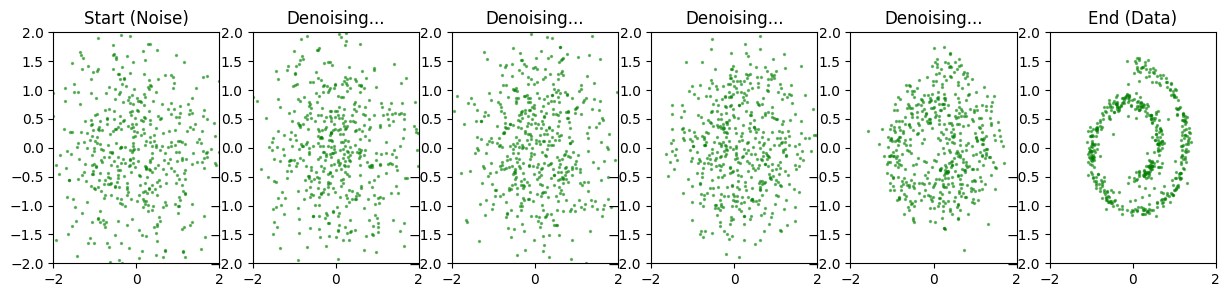

In [7]:
@torch.no_grad()
def p_sample_loop(n_samples=500):
    # Start with pure noise
    x = torch.randn((n_samples, 2)).to(device)
    
    # Store history for visualization
    history = [x.cpu().numpy()]
    
    for i in reversed(range(n_steps)):
        t = torch.full((n_samples,), i, dtype=torch.long, device=device)
        
        # Predict noise
        predicted_noise = model(x, t)
        
        # Get coefficients
        alpha = alphas[i]
        alpha_bar = alphas_bar[i]
        beta = betas[i]
        
        # Add noise sigma (except for last step t=0)
        if i > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
            
        # Update x_{t-1}
        # Formula: mean + sigma * z
        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_bar))) * predicted_noise) + torch.sqrt(beta) * noise
        
        if i % 20 == 0 or i == 0:
            history.append(x.cpu().numpy())
            
    return x, history

final_samples, history = p_sample_loop()

# Visualization of the Reverse Process
plt.figure(figsize=(15, 3))
titles = ["Initial Noise (T=100)", "t=80", "t=60", "t=40", "t=20", "Final Result (t=0)"]

# We stored history backwards (T -> 0). Let's plot selected steps.
display_indices = [0, 1, 2, 3, 4, 5] 

for i, idx in enumerate(display_indices):
    plt.subplot(1, 6, i+1)
    data_slice = history[idx]
    plt.scatter(data_slice[:, 0], data_slice[:, 1], s=2, color='green', alpha=0.5)
    plt.xlim(-2, 2); plt.ylim(-2, 2)
    if i == 0: plt.title("Start (Noise)")
    elif i == 5: plt.title("End (Data)")
    else: plt.title(f"Denoising...")

plt.show()

### Conclusion

You should see the random cloud of points slowly contracting and curling up into the Swiss Roll shape as the process continues.

**Takeaway:** Diffusion is just iteratively nudging points from a low-density region (noise) to a high-density region (data manifold). By learning the gradient of the data distribution (via predicting noise), the model learns the "vector field" that points towards the data.